In [1]:
import numpy as np
import os
import pandas as pd
import sys
import lhapdf

In [2]:
 sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")

In [3]:
lhapdf.pathsPrepend('/home/sam/miniconda3/pkgs/share/LHAPDF')

In [ ]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)

In [26]:
norm = 0
for ik,k in enumerate(momentum['k']):
    norm += k**2*0.05*momentum['rk'][ik]
print(4*np.pi*norm/(2*np.pi**3))

3.999977062338211


> # Function & Class Definitions:

In [4]:
class PDF:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.quarks = {'d': 1, 'u': 2, 's': 3, 'c': 4, 'b': 5,
                       'db': -1, 'ub': -2, 'sb': -3, 'cb': -4, 'bb': -5}
        
#     def __call__(self, i, xs, qs):
#         if isinstance(i, str):
#             i = self.quarks[i]
#         xfx = np.zeros([len(xs), len(qs)])
#         for ix, x in enumerate(xs):
#             print(qs)
#             for iq, q in enumerate(qs):
#                 print(i,x,q)
#                 xfx[ix, iq] = self.pdf.xfxQ(i, x, q)
#         return xfx

    def __call__(self, i, xs, ys, E):
        if isinstance(i, str):
            i = self.quarks[i]
        xfx = np.zeros([len(xs), len(ys)])
        for ix, x in enumerate(xs):
            for iy, y in enumerate(ys):
                q           = np.sqrt(2*m_p*E*x*y)
                xfx[ix, iy] = self.pdf.xfxQ(i, x, q)
        return xfx

In [5]:
class Dataset:
    """
    Class to store the data from Huma in a nice to access format
    """
    def __init__(self, prefix):
        self.filenames = [os.path.join(prefix, f) for f in os.listdir(prefix) if os.path.isfile(os.path.join(prefix, f)) and 'swp' not in f and 'DS' not in f]
        self.data = []
        for filename in self.filenames:
            pdf_set = filename.split('_')[-2]
            df = pd.read_csv(filename, sep='\s+', names=['E', 'Q2', 'x', 'y', 'F1', 'F2', 'sigma'], dtype=np.float64)
            df['pdf'] = pdf_set
            self.data.append(df)
        self.data = pd.concat(self.data)
        self.data = self.data.sort_values(by=['pdf', 'E'])
        
    def points(self):
        pdf_mask = self.data['pdf'] == 'cteq'
        return self.data[pdf_mask][['E', 'Q2', 'x', 'y']].to_numpy()
    
    def data(self, pdf_set):
        pdf_mask = self.data['pdf'] == pdf_set
        return self.data[pdf_mask][['F1', 'F2', 'sigma']]

In [6]:
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a**2)
m_p       = 0.938    # mass of proton in GeV.

In [7]:
def q2f(E, xs, ys):
    """
    Takes arrays of x and y values, and incoming electron beam energy. 
    Outputs corresponding array of q**2's.
    """
    q2 = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            q2[ix,iy] = 2*m_p*E*x*y # Thank you Noemi - derived in notes!
    return q2

$$\begin{align} \frac{F_2^{ep}(x)}{x} &= \frac{4}{9}(u(x)+\bar{u}(x))+\frac{1}{9}(d(x)+\bar{d}(x))+\frac{1}{9}(s(x)+\bar{s}(x))+ ... \end{align}$$

In [8]:
def F2_ep(pdf, E, xs, ys):
    """
    electron-proton scattering F2 expression. (7.4.56)
    """
    series = (4/9)*(pdf("u",xs,ys,E) + pdf("ub",xs,ys,E)) +\
             (1/9)*(pdf("d",xs,ys,E) + pdf("db",xs,ys,E)) +\
             (1/9)*(pdf("s",xs,ys,E) + pdf("sb",xs,ys,E))
    return series

In [9]:
def F2_en(pdf, E, xs, ys):
    """
    electron-neutron scattering F2 expression. (7.4.57)
    """
    series = (4/9)*(pdf("d",xs,ys,E) + pdf("db",xs,ys,E)) +\
             (1/9)*(pdf("u",xs,ys,E) + pdf("ub",xs,ys,E))+\
             (1/9)*(pdf("s",xs,ys,E) + pdf("sb",xs,ys,E))
    return series

$$\begin{align} F_1(x) = \left\{
        \begin{array}{ll}
            0 & \quad \textrm{spin-zero partons} \\
            \left(\frac{1}{2x}\right)F_2(x) & \quad \textrm{spin-$\frac{1}{2}$ partons}
        \end{array}
    \right.\end{align}$$

In [10]:
def F1_ep(pdf, E, xs, ys):
    """
    Quiggs Eq. (7.4.52), electron-proton case.
    Takes LHAPDF data set, incoming electron beam energy, array xs and ys of x and y values.
    """
    f1 = F2_ep(pdf,E,xs,ys)
    for ix, x in enumerate(xs):
        f1[ix] *= (1/(2*x))       # this is suspect to break with array formats?
    return f1

In [11]:
def F1_en(pdf, E, xs, ys):
    """
    electron-neutron case: very similar to F1_ep() function.
    """
    f1 = F2_en(pdf,E,xs,ys)
    for ix, x in enumerate(xs):
        f1[ix] *= (1/(2*x))       # this is suspect to break with array formats?
    return f1

$$\begin{align} \frac{d^2\sigma}{dxdy} &= \frac{4\pi \alpha^2 s}{Q^4}[F_2(x)(1-y)+F_1(x)xy^2]\end{align}$$

In [12]:
def functional(pdf, E, xs, ys):
    """
    Bracketed term calculation. Need LHAPDF data set, incoming electron beam energy, arrays xs and ys.
    """
    left = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            left[ix,iy] = (1-y)
    right = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            right[ix,iy] = y**2*x#pow(y,2)*x
            
    return (F2_ep(pdf,E,xs,ys)*left + F1_ep(pdf,E,xs,ys)*right)

In [13]:
def cross_section(pdf, E, xs, ys, q2s):
    """
    Calculates d2sigma/dxdy. Need LHAPDF data set, incoming electron beam energy, arrays xs and ys.
    """
    s  = m_p**2 + 2*E * m_p     # invariant mass.
    #cs = prefactor * s / q2f(E,xs,ys)**2 * functional(pdf,E,xs,ys)
    cs = prefactor * s / q2s**2 * functional(pdf,E,xs,ys)
    return conversion(E,cs)

In [34]:
def conversion(E, cs):
    gevtocm = 0.19733**2*1e-26
    d2sig   = cs*gevtocm*1e+32/E
    return d2sig # double check this soon.

> # Testing Grounds:

In [15]:
obj = Dataset('NumbersHuma')

In [16]:
obj.points()

array([[3.00000000e+00, 1.40739000e-02, 5.00000000e-02, 5.00000000e-02],
       [3.00000000e+00, 2.81478000e-02, 5.00000000e-02, 1.00000000e-01],
       [3.00000000e+00, 4.22217000e-02, 5.00000000e-02, 1.50000000e-01],
       ...,
       [1.50000000e+01, 2.27293485e+01, 9.50000000e-01, 8.50000000e-01],
       [1.50000000e+01, 2.40663690e+01, 9.50000000e-01, 9.00000000e-01],
       [1.50000000e+01, 2.54033895e+01, 9.50000000e-01, 9.50000000e-01]])

In [17]:
print(np.unique(obj.data['pdf']))
obj.data

['cteq' 'mmht']


,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,cteq
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,cteq
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,cteq
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,cteq
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,cteq
...,...,...,...,...,...,...,...,...
185,15.0,20.055308,0.95,0.75,0.000019,0.000037,0.000001,mmht
186,15.0,21.392328,0.95,0.80,0.000019,0.000036,0.000001,mmht
187,15.0,22.729349,0.95,0.85,0.000018,0.000035,0.000001,mmht
188,15.0,24.066369,0.95,0.90,0.000018,0.000034,0.000001,mmht


In [18]:
dat = Dataset('nnlogrid-comparison')
print(np.unique(dat.data['pdf']))
dat.data

['mmht']


,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,mmht
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,mmht
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,mmht
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,mmht
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,mmht
...,...,...,...,...,...,...,...,...
185,15.0,20.055308,0.95,0.75,0.000019,0.000037,0.000001,mmht
186,15.0,21.392328,0.95,0.80,0.000019,0.000036,0.000001,mmht
187,15.0,22.729349,0.95,0.85,0.000018,0.000035,0.000001,mmht
188,15.0,24.066369,0.95,0.90,0.000018,0.000034,0.000001,mmht


> # Let's compare tables:

In [19]:
# isolate 3 GeV entries.
df = obj.data
GeV = (df['E'] == 3) & (df['pdf'] == 'cteq')
bench = df[GeV]
bench

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,cteq
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,cteq
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,cteq
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,cteq
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,cteq
...,...,...,...,...,...,...,...,...
185,3.0,4.011062,0.95,0.75,0.000118,0.000118,0.000192,cteq
186,3.0,4.278466,0.95,0.80,0.000114,0.000114,0.000185,cteq
187,3.0,4.545870,0.95,0.85,0.000110,0.000110,0.000178,cteq
188,3.0,4.813274,0.95,0.90,0.000106,0.000106,0.000172,cteq


In [20]:
# again, but for new data nnlogrid.
frame = dat.data
GeV = (frame['E'] == 3)
test = frame[GeV]
test

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,mmht
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,mmht
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,mmht
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,mmht
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,mmht
...,...,...,...,...,...,...,...,...
185,3.0,4.011062,0.95,0.75,0.000045,0.000086,0.000074,mmht
186,3.0,4.278466,0.95,0.80,0.000043,0.000083,0.000071,mmht
187,3.0,4.545870,0.95,0.85,0.000042,0.000080,0.000068,mmht
188,3.0,4.813274,0.95,0.90,0.000040,0.000077,0.000066,mmht


In [21]:
E  = 3.0 ; nx = 19 ; ny = 19
xs = np.linspace(0.05,0.95,nx) ; ys = np.linspace(0.05,0.95,ny)
pdf = PDF('cteq66', 0)
# initialize only once, whoops!

In [35]:
"""
IMPORTANT: arrays have been flattened to accomodate the pandas dataframe.
a.flatten() is used in general, assuming that the lists format like so:
a[0] is 0th x-value; a[0][0] is the 0th y-value.
"""
q2s = q2f(E,xs,ys)

s2 = cross_section(pdf,E,xs,ys,q2s).flatten()
q2 = q2f(E,xs,ys).flatten()

f1 = F1_ep(pdf,E,xs,ys).flatten()
f2 = F2_ep(pdf,E,xs,ys).flatten()

# create iterated x & y entries.
Cxs = np.empty([len(xs), len(ys)])
Cys = np.empty([len(xs), len(ys)])
for ix,x in enumerate(xs):
    for iy,y in enumerate(ys):
        Cxs[ix,iy] = x
        Cys[ix,iy] = y
cx = Cxs.flatten() ; cy = Cys.flatten()

d = {'E':3.0,'Q2':q2,'x':cx,'y':cy,'F1':f1,'F2':f2,'sigma':s2,'pdf':'cteq66'}
dfC = pd.DataFrame(d)
dfC

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.01407,0.05,0.05,0.032532,0.003253,884.083937,cteq66
1,3.0,0.02814,0.05,0.10,0.066726,0.006673,431.287000,cteq66
2,3.0,0.04221,0.05,0.15,0.102247,0.010225,279.525165,cteq66
3,3.0,0.05628,0.05,0.20,0.138919,0.013892,203.394158,cteq66
4,3.0,0.07035,0.05,0.25,0.176616,0.017662,157.675139,cteq66
...,...,...,...,...,...,...,...,...
356,3.0,4.00995,0.95,0.75,0.000089,0.000169,0.000315,cteq66
357,3.0,4.27728,0.95,0.80,0.000085,0.000162,0.000260,cteq66
358,3.0,4.54461,0.95,0.85,0.000082,0.000156,0.000219,cteq66
359,3.0,4.81194,0.95,0.90,0.000080,0.000151,0.000186,cteq66


> # Visual comparison:

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

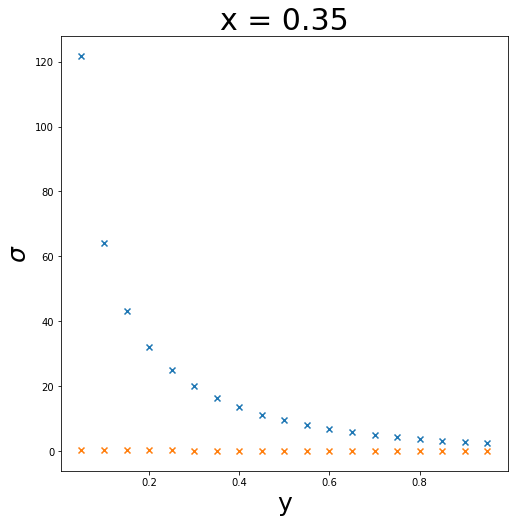

In [36]:
plt.figure(figsize=(8,8)) ; plt.rc('axes', labelsize=25, titlesize=30)

xval = 0.35 ; s = "x = {}".format(xval)
xm = dfC['x'] == xval
plt.scatter(dfC['y'][xm],dfC['sigma'][xm],marker='x')
plt.scatter(bench['y'][xm],bench['sigma'][xm],marker='x')
plt.scatter(test['y'][xm],test['sigma'][xm],marker='x')
plt.xlabel('y') ; plt.ylabel('$\sigma$') ; plt.title(s)

plt.show()

In [26]:
# print(dfC['sigma'][xm])

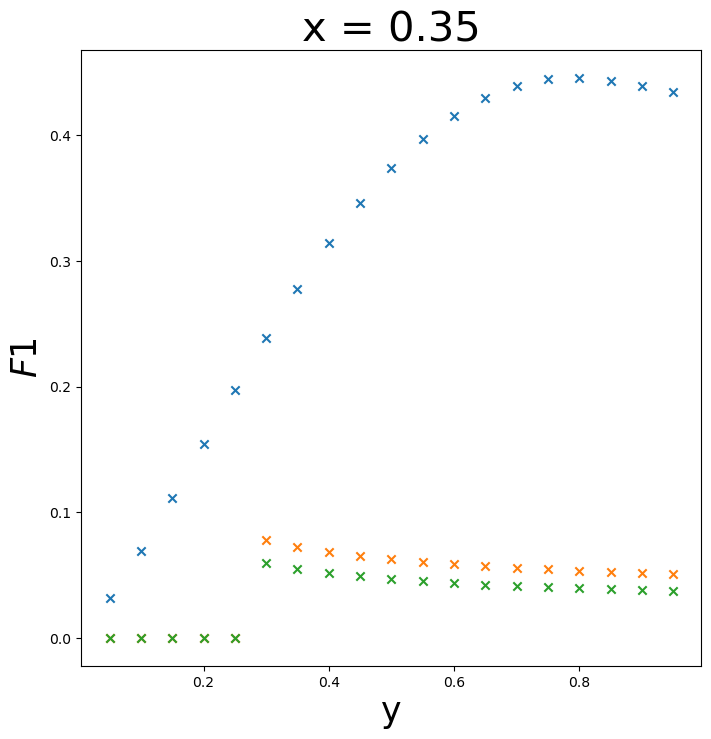

In [27]:
plt.figure(figsize=(8,8)) ; plt.rc('axes', labelsize=25, titlesize=30)

xval = 0.35 ; s = "x = {}".format(xval)
xm = dfC['x'] == xval
plt.scatter(dfC['y'][xm],dfC['F1'][xm],marker='x')
plt.scatter(bench['y'][xm],bench['F1'][xm],marker='x')
plt.scatter(test['y'][xm],test['F1'][xm],marker='x')
plt.xlabel('y') ; plt.ylabel('$F1$') ; plt.title(s)

plt.show()

In [28]:
E  = 3.0 ; nx = 1 ; ny = 19
xs = [0.35]
ys = np.linspace(0.05,0.95,ny)
q2 = q2f(E,xs,ys)
print(q2)

[[0.09849 0.19698 0.29547 0.39396 0.49245 0.59094 0.68943 0.78792 0.88641
  0.9849  1.08339 1.18188 1.28037 1.37886 1.47735 1.57584 1.67433 1.77282
  1.87131]]


In [29]:
f1 = F1_ep(pdf,E,xs,ys)
f2 = F2_ep(pdf,E,xs,ys)

plt.plot(ys,f2[0,:])

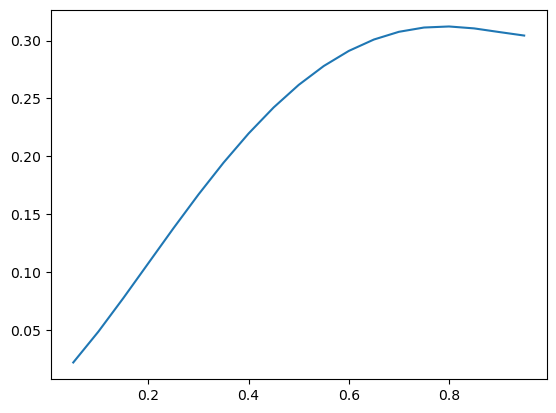

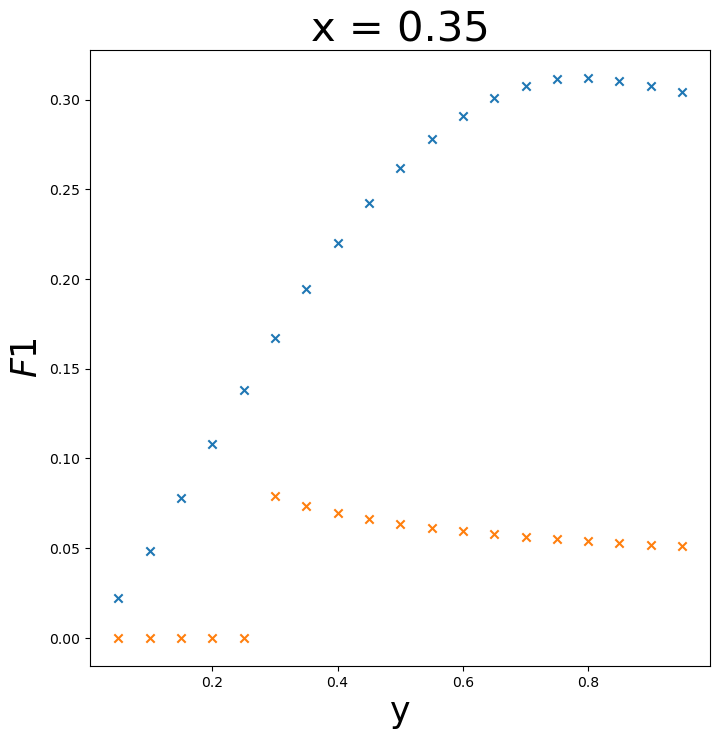

In [30]:
plt.figure(figsize=(8,8)) ; plt.rc('axes', labelsize=25, titlesize=30)

xval = 0.35 ; s = "x = {}".format(xval)
xm = dfC['x'] == xval
plt.scatter(dfC['y'][xm],dfC['F2'][xm],marker='x')
plt.scatter(bench['y'][xm],bench['F2'][xm],marker='x')
plt.xlabel('y') ; plt.ylabel('$F1$') ; plt.title(s)

plt.show()

In [31]:
 E  = 3.0 ; nx = 1 ; ny = 19
xs = [0.35]
ys = np.linspace(0.05,0.95,ny)
q2 = q2f(E,xs,ys)
up=pdf("u",xs,ys,E)

In [32]:
print(up)

[[0.04365511 0.09646903 0.15425363 0.21420096 0.27407016 0.33203437
  0.38662359 0.436691   0.48138465 0.52011912 0.55254624 0.57852488
  0.59809058 0.61142579 0.6188313  0.62069965 0.61749061 0.61130821
  0.60532595]]


In [33]:
plt.plot(ys,up[0,:])